# Read IDL results  for Celerite

In [2]:
import linmix
import numpy as np 
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib import rcParams
from astropy.table import Table
from astropy.table import vstack
from astropy.table import Column
import os
import scipy
import matplotlib.lines as mlines
import seaborn as sns 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18



show the five-band Chelsea's results ... 

Results for  SF
1 mean A= -0.47516608244115915
1 mean C= 0.12207877338945022
1 mean D= 0.14811451173144377
2 mean A= -0.44811253773093757
2 mean C= 0.12718306430052495
2 mean D= 0.1451527604077876
3 mean A= -0.48920405041816284
3 mean C= 0.11734994760452622
3 mean D= 0.11976867053250172
4 mean A= -0.48581444898003284
4 mean C= 0.12265063725144242
4 mean D= 0.11583378556857163
5 mean A= -0.478172121382365
5 mean C= 0.12032661340320921
5 mean D= 0.10978183889787496
Band-averaged A =  -0.4752938481905315
Band-averaged C =  0.12191780718983061
Band-averaged D =  0.12773031342763594


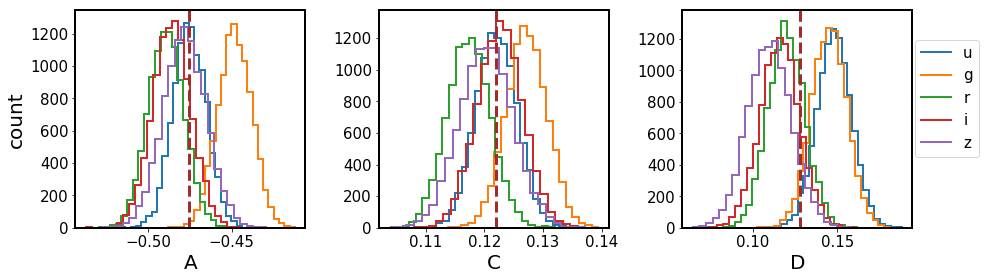

In [14]:
# Read in the results of MLINMIX_ERR fitting ....
%matplotlib inline
import matplotlib.lines as mlines
import seaborn as sns 
current_palette = sns.color_palette()

# this used M_i from s82drw 
fig,ax = plt.subplots(1,3, figsize=(15,4))
A=[]; C=[]; D=[]
b = 'ugriz'
par = 'SF'#'tau'#'SF'# 'SF'#'tau'#  'SF'#tau' # 'SF' 
lw=2
nbins = 25
ax_legend_handles =  []
print('Results for ', par)
for band in range(1,6):
    #d = '../IDL/line5_ACD_M_i/'   # using 'M_i' - K -corrected to z=0 DBQSO
    #d = '../IDL/line5_ACD_M_i_corr/'   # using 'M_i_corr' - K -corrected to z=2 DBQSO
    #d = '../IDL/line5_ACD_MI_Z2_shifted/'     # using 'MI_Z2 + 0.596  - K-corrected to z=0 
    d = '../IDL/line5_ACD_MI_Z2/'  # using MI_Z2  - K-corrected to z=2 
    #d = '../IDL/mlinmixerr2_line5_ACD_MI_Z2/' # using 'MI_Z2', k-corr to z=2, 
                                            # but with mlinmix_err2
    #d = '../IDL/mlinmixerr2_line5_ACD_M_i/'# using 'M_i" k-corr to z=0
    f = 'coeff'+par+'o_mcmc2_'+str(band)+'_E0a.fits'
    post = Table.read(d+f, format='fits')
    
    c = current_palette[band-1]
    
    ax[0].hist(post['ALPHA'],histtype='step',color=c,lw=lw, bins=nbins)
    A.append(np.mean(post['ALPHA']))
    print(band, 'mean A=', np.mean(post['ALPHA']))
    
    ax[1].hist(post['BETA'][:,0],histtype='step',color=c,lw= lw,bins=nbins)
    print(band, 'mean C=', np.mean(post['BETA'][:,0]))
    C.append(np.mean(post['BETA'][:,0]))
    
    ax[2].hist(post['BETA'][:,1],histtype='step',color=c,lw=lw ,bins=nbins)
    print(band, 'mean D=', np.mean(post['BETA'][:,1]))
    D.append(np.mean(post['BETA'][:,1]))
    
    line = mlines.Line2D([], [],  color=c, label=b[band-1],lw=lw)
    ax_legend_handles.append(line)
    
ax[0].set_ylabel('count')
ax[0].set_xlabel('A')

coeffs = [A,C,D]
names = ['A', 'C', 'D']
for i in range(len(coeffs)) : 
    ax[i].axvline(np.mean(coeffs[i]), ls='--', lw=3, c='brown')
    ax[i].set_xlabel(names[i])

ax[2].legend(loc='upper left', handles = ax_legend_handles,
             bbox_to_anchor=(0.98, 0.9), fontsize=15,fancybox=True)
fig.subplots_adjust(wspace=0.32)

print('Band-averaged A = ', np.mean(A),)
print('Band-averaged C = ', np.mean(C))
print('Band-averaged D = ', np.mean(D))
#mlinmix_diff['mlinmix3'] = [np.mean(A), np.mean(C), np.mean(D)]

plt.savefig('Chelsea_ugriz_Shen2011.png', bbox_inches='tight', dpi=100)

show the single-band results .... 

3 mean A= 2.603463671159337
3 mean C= 0.022398178266601256
3 mean D= 0.16389184026061931


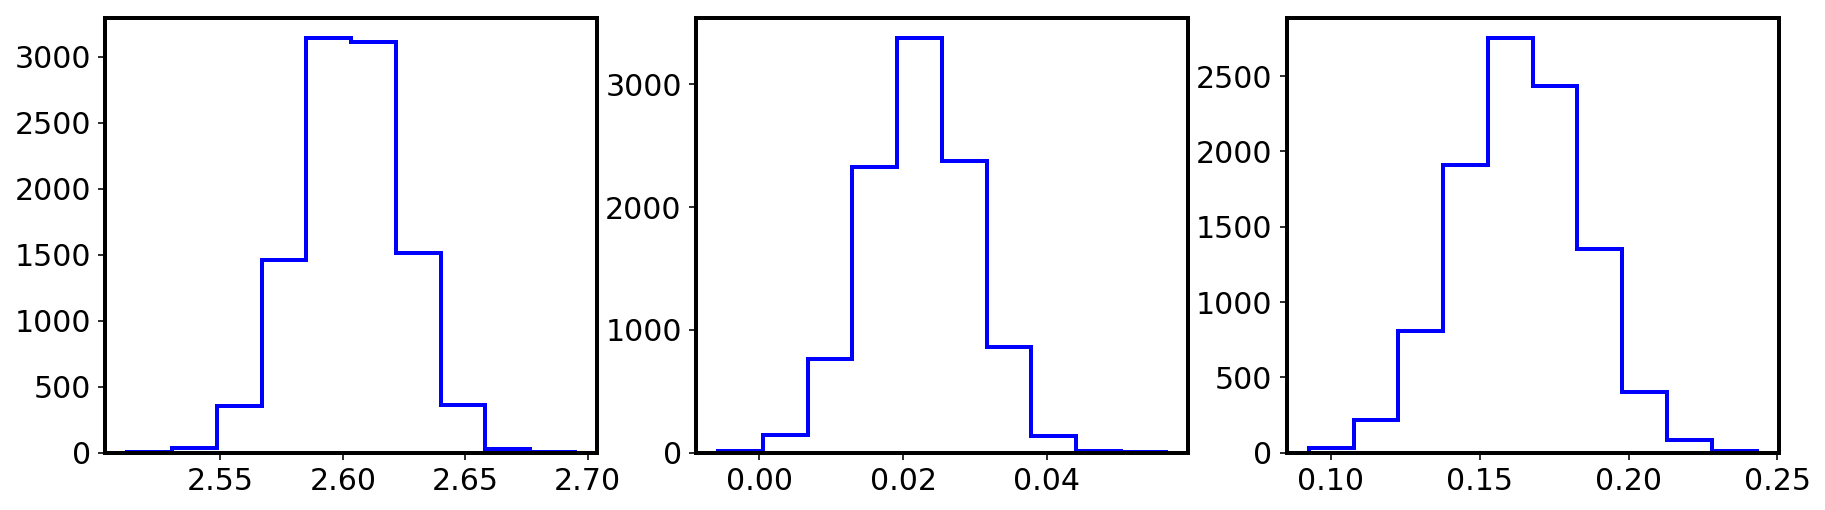

In [131]:
%matplotlib inline

band = 3 
par = 'tau'
f = 'coeff'+par+'o_mcmc2_'+str(band)+'_E0a.fits'
#d = '../IDL/line5_ACD_M_i_corr/'
#d = '../IDL/line5_celerite_ACD_M_i_corr_SDSS-PS1/'
#d = '../IDL/line5_celerite_ACD_M_i_corr_SDSS/'
d = '../IDL/line5_celerite_MI_Z2_SDSS/'
c = 'blue'
lw=2
post = Table.read(d+f, format='fits')

fig,ax = plt.subplots(1,3, figsize=(15,4))
A=[]; C=[]; D=[]

ax[0].hist(post['ALPHA'],histtype='step',color=c,lw=lw)
A.append(np.mean(post['ALPHA']))
print(band, 'mean A=', np.mean(post['ALPHA']))

ax[1].hist(post['BETA'][:,0],histtype='step',color=c,lw= lw)
print(band, 'mean C=', np.mean(post['BETA'][:,0]))
C.append(np.mean(post['BETA'][:,0]))

ax[2].hist(post['BETA'][:,1],histtype='step',color=c,lw=lw )
print(band, 'mean D=', np.mean(post['BETA'][:,1]))
D.append(np.mean(post['BETA'][:,1]))



Compare posterior samples, all using IDL with M_i_corr,  mass_bh (Shen2008)
    * Chelsea r-band  
    * Celerite, combined r-band, SDSS only 
    * Celerite, combined r-band, SDSS-PS1 

 
../IDL/line5_ACD_MI_Z2/
3 mean A= 2.4323886272897273
3 mean C= 0.011207336099430625
3 mean D= 0.16309971616965474
 
../IDL/line5_celerite_MI_Z2_SDSS/
3 mean A= 2.603463671159337
3 mean C= 0.022398178266601256
3 mean D= 0.16389184026061931
 
../IDL/line5_celerite_MI_Z2_SDSS-PS1/
3 mean A= 2.2317035109979346
3 mean C= 0.0636233773976418
3 mean D= 0.09357750033262893
Saving as  posterior_IDL_Chelsea_Celerite_MI_Z2.png


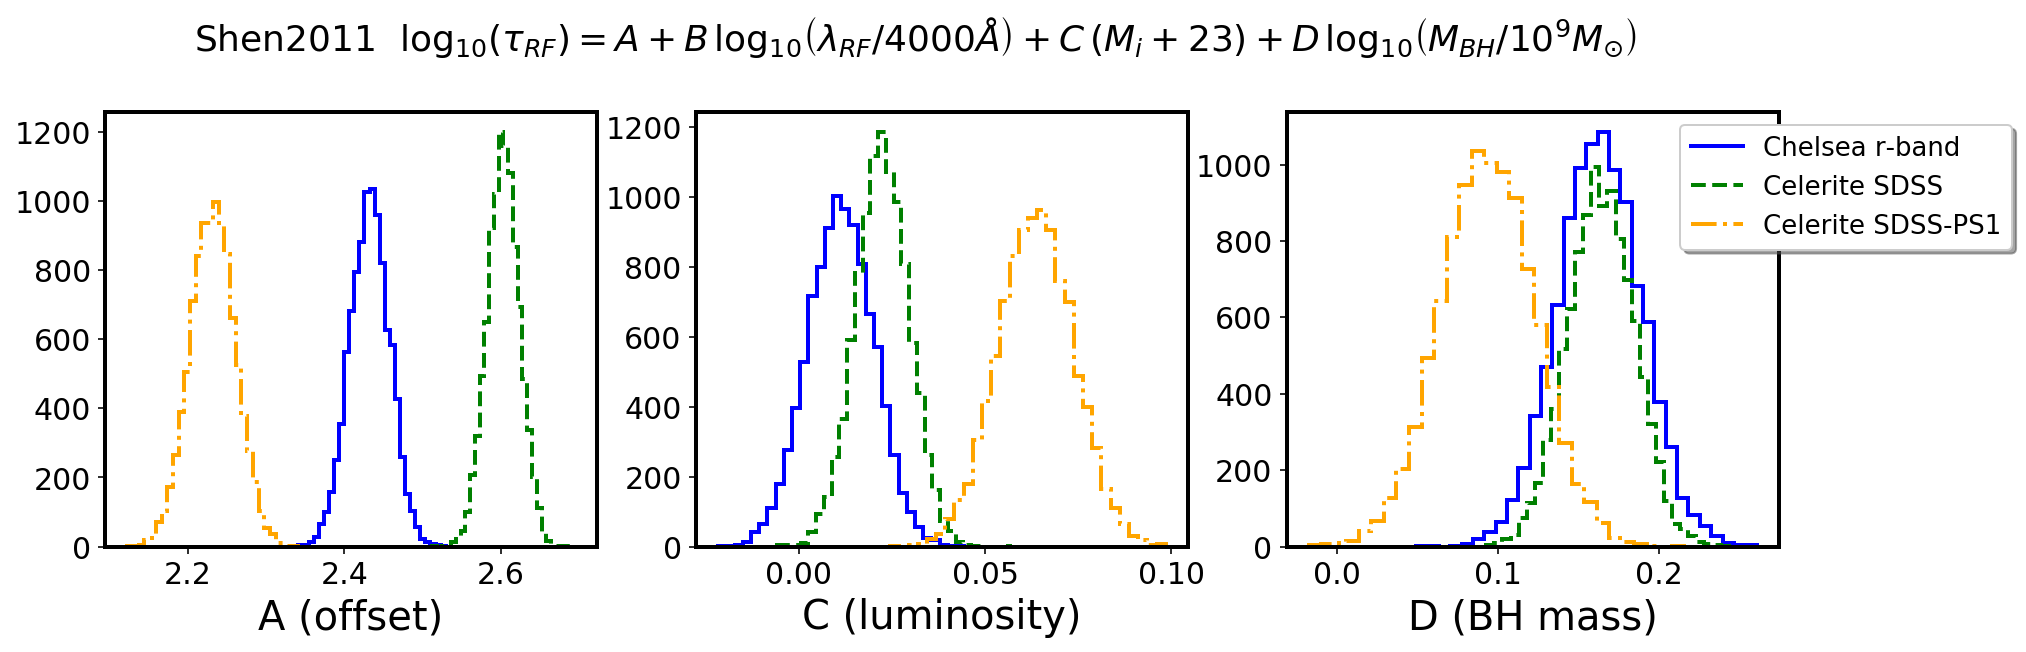

In [150]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
band = 3 
par = 'tau'
f = 'coeff'+par+'o_mcmc2_'+str(band)+'_E0a.fits'

catalog = 'MI_Z2'# 'M_i_corr' #  # 'M_i_corr' # 'M_i_corr  
pre = 'Shen2011'# 'Shen2008'# 
ds = ['../IDL/line5_ACD_'+catalog+'/',
'../IDL/line5_celerite_'+catalog+'_SDSS/',
'../IDL/line5_celerite_'+catalog+'_SDSS-PS1/']
colors= ['blue','green', 'orange',  'red']
ls = ['solid' , 'dashed', 'dashdot', 'dotted',  ]
labels = ['Chelsea r-band', 'Celerite SDSS', 'Celerite SDSS-PS1']
lw=2
A=[]; C=[]; D=[]
fig,ax = plt.subplots(1,3, figsize=(15,4))
i = 0 
ax_legend_handles = [] 
nbins = 30
for d in ds : 
    print(' ')
    print(d)
    post = Table.read(d+f, format='fits')
    ax[0].hist(post['ALPHA'],histtype='step',color=colors[i],lw=lw, 
               ls=ls[i],bins=nbins)
    A.append(np.mean(post['ALPHA']))
    print(band, 'mean A=', np.mean(post['ALPHA']))

    ax[1].hist(post['BETA'][:,0],histtype='step',color=colors[i],lw= lw,
               ls=ls[i],bins=nbins)
    print(band, 'mean C=', np.mean(post['BETA'][:,0]))
    C.append(np.mean(post['BETA'][:,0]))

    ax[2].hist(post['BETA'][:,1],histtype='step',color=colors[i],lw=lw ,
               ls=ls[i],bins=nbins)
    print(band, 'mean D=', np.mean(post['BETA'][:,1]))
    D.append(np.mean(post['BETA'][:,1]))

    line = mlines.Line2D([], [],  color=colors[i], label=labels[i],lw=2,
                        ls=ls[i])
    ax_legend_handles.append(line)
    i += 1 
ax[2].legend(loc='upper right', handles = ax_legend_handles,
             bbox_to_anchor=(1.5, 1.0),
             ncol=1, fancybox=True, shadow=True, fontsize=13 ) 
fig.suptitle(pre+'  '+r'$\log_{10}{(\tau_{RF})} = A + $'+\
             r'$B \,\log_{10}\left( \lambda_{RF} / 4000 \AA \right) +$'+\
             r'$C \,(M_{i} + 23) + $'+\
             r'$D\, \log_{10}{\left( M_{BH} / 10^{9} M_{\odot}  \right)}  $'
       , fontsize=18, y = 1.05)


ax[0].set_xlabel('A (offset)')
ax[1].set_xlabel('C (luminosity)')
ax[2].set_xlabel('D (BH mass)')
figname  = 'posterior_IDL_Chelsea_Celerite_'+catalog+'.png'
print('Saving as ', figname)
plt.savefig(figname, bbox_inches='tight',
           dpi=100)

Plot the above only for C,D coeffs  : 

 
../IDL/line5_ACD_MI_Z2/
3 mean C= 0.11734994760452622
3 mean D= 0.11976867053250172
 
../IDL/line5_celerite_MI_Z2_SDSS/
3 mean C= 0.11735449082549385
3 mean D= 0.12030430213708267
 
../IDL/line5_celerite_MI_Z2_SDSS-PS1/
3 mean C= 0.10492633387371521
3 mean D= 0.11097680481510176
Saving as  posterior_IDL_Chelsea_Celerite_CD_MI_Z2_SF.png


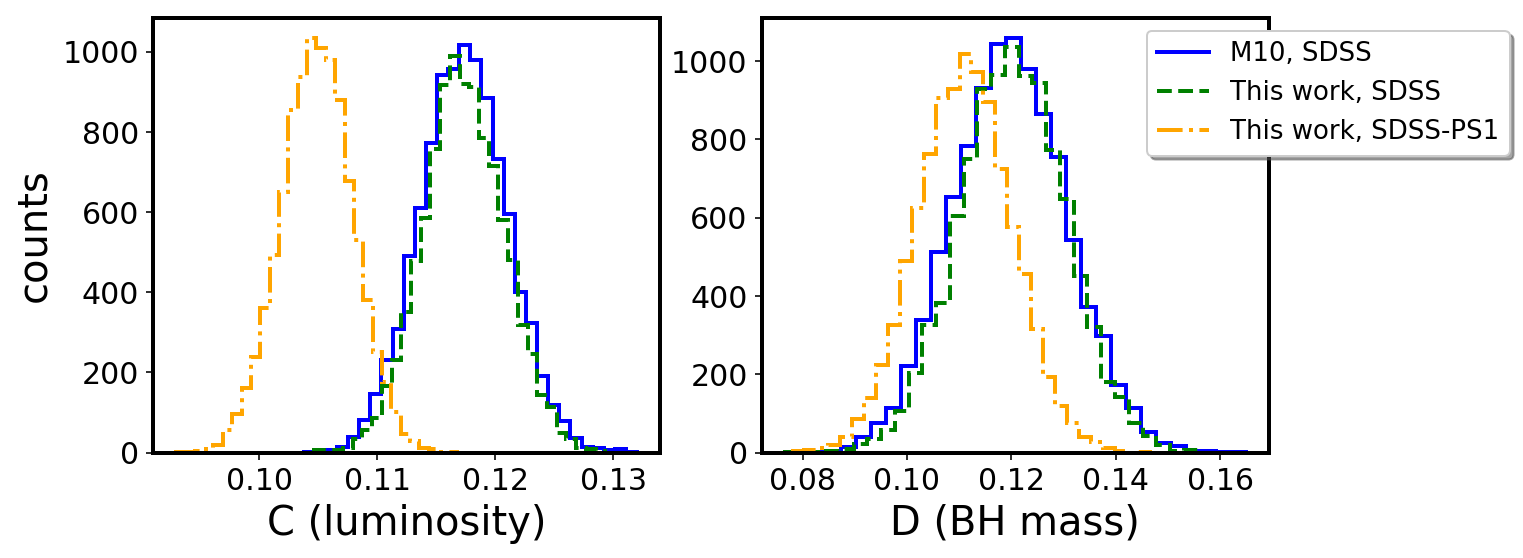

In [7]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
band = 3 

par = 'SF'#'tau' #  'SF' # \tau
f = 'coeff'+par+'o_mcmc2_'+str(band)+'_E0a.fits'

catalog = 'MI_Z2'# 'M_i_corr' #  # 'M_i_corr' # 'M_i_corr  
pre = 'Shen2011'# 'Shen2008'# 
ds = ['../IDL/line5_ACD_'+catalog+'/',
'../IDL/line5_celerite_'+catalog+'_SDSS/',
'../IDL/line5_celerite_'+catalog+'_SDSS-PS1/']
colors= ['blue','green', 'orange',  'red']
ls = ['solid' , 'dashed', 'dashdot', 'dotted',  ]
labels = ['M10, SDSS', 'This work, SDSS', 'This work, SDSS-PS1']
lw=2
A=[]; C=[]; D=[]
fig,ax = plt.subplots(1,2, figsize=(10,4))
i = 0 
ax_legend_handles = [] 
nbins = 30
for d in ds : 
    print(' ')
    print(d)
    post = Table.read(d+f, format='fits')

    ax[0].hist(post['BETA'][:,0],histtype='step',color=colors[i],lw= lw,
               ls=ls[i],bins=nbins)
    print(band, 'mean C=', np.mean(post['BETA'][:,0]))
    C.append(np.mean(post['BETA'][:,0]))

    ax[1].hist(post['BETA'][:,1],histtype='step',color=colors[i],lw=lw ,
               ls=ls[i],bins=nbins)
    print(band, 'mean D=', np.mean(post['BETA'][:,1]))
    D.append(np.mean(post['BETA'][:,1]))

    line = mlines.Line2D([], [],  color=colors[i], label=labels[i],lw=2,
                        ls=ls[i])
    ax_legend_handles.append(line)
    i += 1 
ax[1].legend(loc='upper right', handles = ax_legend_handles,
             bbox_to_anchor=(1.5, 1.0),
             ncol=1, fancybox=True, shadow=True, fontsize=13 )

ax[0].set_xlabel('C (luminosity)')
ax[1].set_xlabel('D (BH mass)')
ax[0].set_ylabel('counts')
figname  = 'posterior_IDL_Chelsea_Celerite_CD_'+catalog+'_'+par+'.png'
print('Saving as ', figname)
plt.savefig(figname, bbox_inches='tight',
           dpi=100)

$\log_{10}{(\tau_{RF})} = A + B \log_{10}\left(\frac{\lambda_{RF}}{4000  }\right) + C (M_{i} + 23) + D \log_{10}{\left( \frac{M_{BH}}{10^{9}  } \right)} + E \log_{10}{(1+z)}$

In [123]:
# Read in a file with MBH, Mi   used for IDL fitting  
cel = Table.read('190228_celerite_J1_shen2007-2011.txt', format='ascii')

Using ACD  from SDSS-only 

(array([2.350e+02, 1.343e+03, 1.074e+03, 4.110e+02, 1.170e+02, 4.400e+01,
        1.200e+01, 9.000e+00, 2.000e+00, 1.000e+00]),
 array([-0.85248385, -0.46720243, -0.08192102,  0.30336039,  0.6886418 ,
         1.07392321,  1.45920463,  1.84448604,  2.22976745,  2.61504886,
         3.00033028]),
 <a list of 1 Patch objects>)

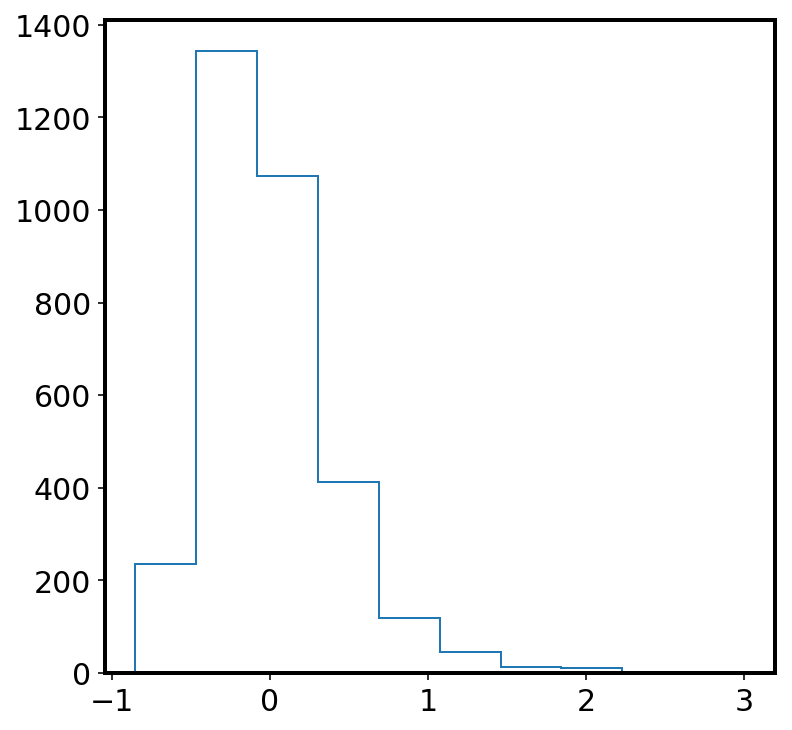

In [124]:
# to get these tau ACD, I used M_i_corr (z=2), and mass_BH  ( from DB_QSO )
# Using tauEXP_sdss only 
A = 2.692
C = 0.0458
D = 0.244

B = 0.17  # fixed 
x = np.log10(cel['lambdaRF'] / 4000 )
y = cel['M_i_corr'] + 23 
z = cel['mass_BH'] - 9  # mass_BH is already a log 
select = cel['mass_BH']  > 0 

log10tauRF_IDL = A + B*x[select]  + C*y[select] + D*z[select]  # from IDL fits 
tauRF_IDL = np.power(10,log10tauRF_IDL)

log10tauRF_cel = np.log10(cel['tauEXP_sdss'][select]) -\
                np.log10(1 + cel['redshift'][select])
tauRF_cel = np.power(10,log10tauRF_cel)
a = np.log10(tauRF_IDL / tauRF_cel)

fig,ax = plt.subplots(1,1,figsize=(6,6))
ax.hist(np.log10(tauRF_IDL / tauRF_cel), histtype='step')

(array([ 87., 418., 643., 652., 522., 393., 270., 141.,  82.,  40.]),
 array([-1.18335958, -0.88649442, -0.58962925, -0.29276409,  0.00410107,
         0.30096623,  0.59783139,  0.89469656,  1.19156172,  1.48842688,
         1.78529204]),
 <a list of 1 Patch objects>)

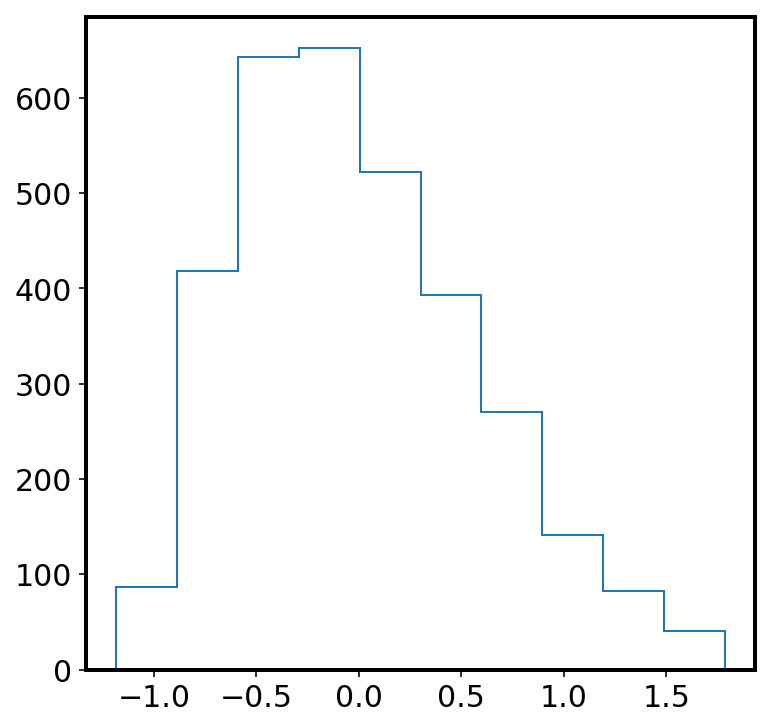

In [125]:
# to get these tau ACD, I used M_i_corr (z=2), and mass_BH  ( from DB_QSO )
# Using tauEXP_sdss-ps1  
A = 2.356
C = 0.1026
D = 0.203

B = 0.17  # fixed 
x = np.log10(cel['lambdaRF'] / 4000 )
y = cel['M_i_corr'] + 23 
z = cel['mass_BH'] - 9  # mass_BH is already a log 
select = cel['mass_BH']  > 0 

log10tauRF_IDL = A + B*x[select]  + C*y[select] + D*z[select]  # from IDL fits 

tauRF_IDL = np.power(10,log10tauRF_IDL)
#tauOBS_IDL = tauRF_IDL * (1+cel['redshift'][select])

log10tauRF_cel = np.log10(cel['tauEXP_sdss-ps1'][select]) -\
                np.log10(1 + cel['redshift'][select])
tauRF_cel = np.power(10,log10tauRF_cel)
#tauOBS_cel = cel['tauEXP_sdss-ps1'][select]

#plt.hist(log10tauRF_IDL, histtype='step', label='IDL')
#plt.hist(log10tauRF_cel, histtype='step', label='Celerite')
#plt.legend()
fig,ax = plt.subplots(1,1,figsize=(6,6))
b = np.log10(tauRF_IDL / tauRF_cel) 
# there is no difference whether I'm comparing here
# rest-frame tau or  observed frame tau,
# because the same shifts have been applied to all quasars 
ax.hist(np.log10(tauRF_IDL / tauRF_cel), histtype='step')


In [126]:
# only select r-band from Chelsea's results,
# that were used for IDL fitting ...
results  = Table.read('../code/s82drw_ugriz.txt', format='ascii')
ch = results[results['band'] == 3]
#ch

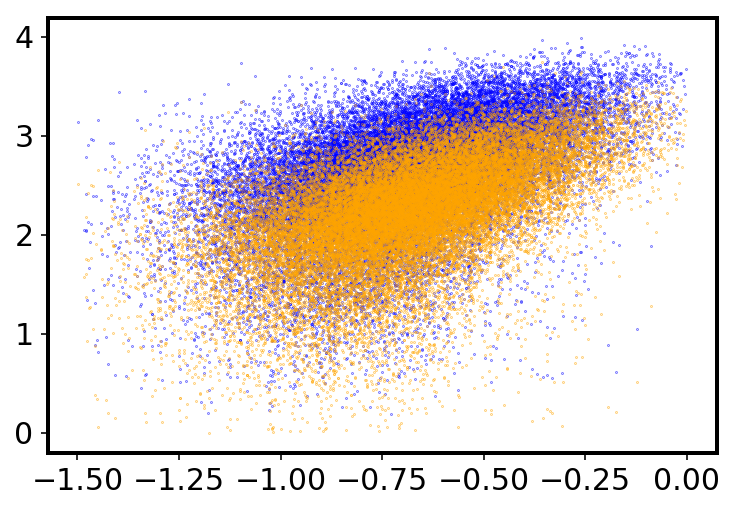

In [127]:
# Show that the log10tau is hte observed frame, not the rest-frame, 
# by reproducing Fig;3 with the 33112 light curves (~1 light curve per band )

extent = [-1.5,0,0,4]


x = np.log10(results['SFinf'])
# assuming stored as rest-frame already : blue  
y = results['log10tau'] 


mx = (extent[0] < x) * (x < extent[1])
my = (extent[2] < y) * (y < extent[3])
m = mx & my 
plt.scatter(x[m], y[m], c='blue', s=0.05)

# assuming stored as obs-frame  : orange 
y = results['log10tau'] - np.log10(1. + results['redshift'])  
mx = (extent[0] < x) * (x < extent[1])
my = (extent[2] < y) * (y < extent[3])
m = mx & my 
plt.scatter(x[m], y[m], c='orange', s=0.05)


So from the above we see that the orange dots (assuming log10tau is obs-frame) are much more aligned with Fig.3 in the paper than the blue dots (assuming log10tau is rest-frame). Therefore log10tau  on the website is the **observed frame** and needs to be divided by 1+z  to shift to rest frame. 

(array([2.100e+01, 3.960e+02, 1.265e+03, 1.558e+03, 7.150e+02, 2.410e+02,
        8.800e+01, 3.100e+01, 1.100e+01, 1.000e+00]),
 array([-1.5 , -1.05, -0.6 , -0.15,  0.3 ,  0.75,  1.2 ,  1.65,  2.1 ,
         2.55,  3.  ]),
 <a list of 1 Patch objects>)

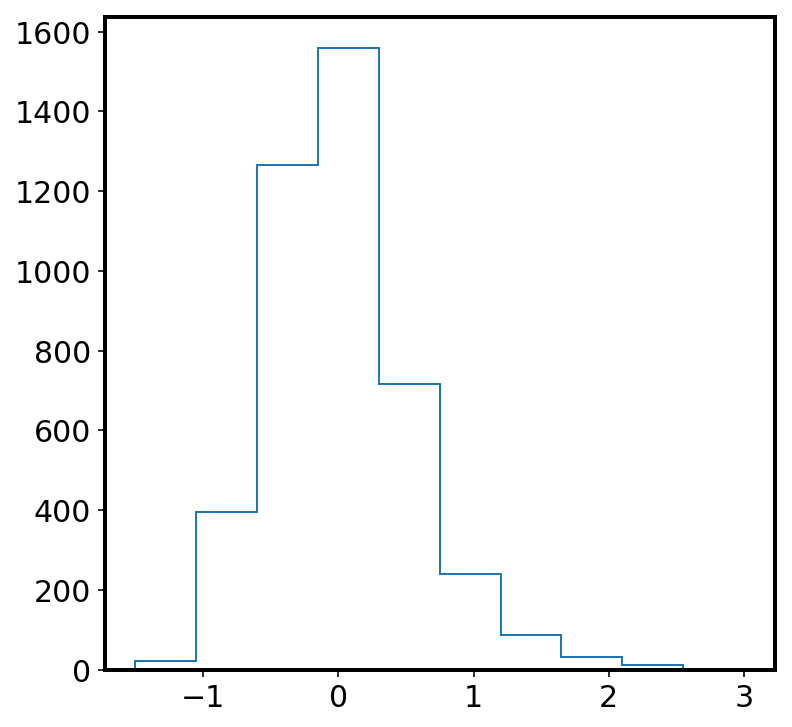

In [128]:
# Here compare IDL fits to Chelsea's r-band only tau 
A = 2.542
C = 0.0411
D = 0.2759

B = 0.17  # fixed 
x = np.log10(ch['lambdaRF'] / 4000 )
y = ch['M_i_corr'] + 23 
z = ch['mass_BH'] - 9  # mass_BH is already a log 
select = ch['mass_BH']  > 0 

log10tauRF_IDL = A + B*x[select]  + C*y[select] + D*z[select]  # from IDL fits 
tauRF_IDL = np.power(10,log10tauRF_IDL)
#tauOBS_IDL = tauRF_IDL * (1+cel['redshift'][select])


log10tauOBS_ch = ch['log10tau'][select] # it's obs frame and needs to be shifted... 
log10tauRF_ch = log10tauOBS_ch -  np.log10(1. + ch['redshift'][select])    
tauRF_ch = np.power(10,log10tauRF_ch)

#tauOBS_cel = cel['tauEXP_sdss-ps1'][select]

#plt.hist(log10tauRF_IDL, histtype='step', label='IDL')
#plt.hist(log10tauRF_cel, histtype='step', label='Celerite')
#plt.legend()
fig,ax = plt.subplots(1,1,figsize=(6,6))

# there is no difference whether I'm comparing here
# rest-frame tau or  observed frame tau,
# because the same shifts have been applied to all quasars 
c = np.log10(tauRF_IDL / tauRF_ch)
ax.hist(np.log10(tauRF_IDL / tauRF_ch), histtype='step',
       range=(-1.5,3))



Plot the ratios of tau -->  A,C,D  given  M_i,  M_BH   ,  to  tau < -- A,C,D, given M_i, M_BH  . 

For each tau, I'm using A,C,D  obtained from fitting these tau with IDL, and M_i_corr, mass_BH (DB_QSO values). Thus there are three sets of A,C,D : 

* using SDSS-only Celerite tauEXP_sdss :
  * A = 2.692, C = 0.0458 , D = 0.244
* using SDSS and PS1 Celerite tauEXP_sdss-ps1 : 
  * A = 2.356, C = 0.1026, D = 0.203
* using Chelsea's SDSS r-band tau  log10tau : 
  * A = 2.69,  C = -0.048, D = 0.256




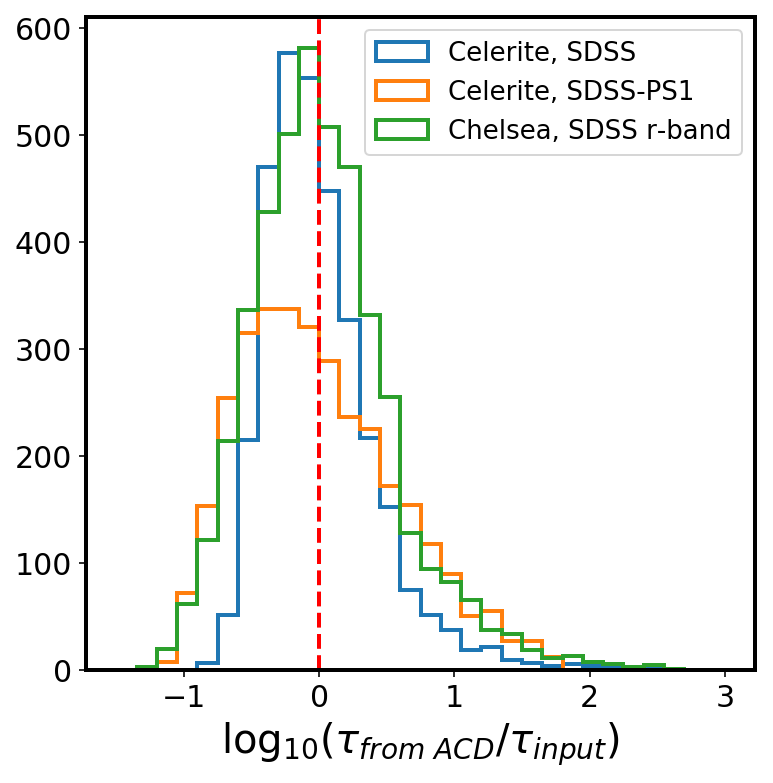

In [130]:
fig,ax = plt.subplots(1,1,figsize=(6,6))
N = 30
r = (-1.5,3)

ax.hist(a, histtype='step', lw=2, label='Celerite, SDSS',range=r, bins=N)
ax.hist(b, histtype='step', lw=2, label='Celerite, SDSS-PS1',range=r,bins=N)
ax.hist(c, histtype='step', lw=2, label='Chelsea, SDSS r-band',range=r,bins=N)
ax.axvline(0, ls='--', lw=2, c='red')
ax.legend(fontsize=13)
ax.set_xlabel(r'$\log_{10}{(\tau_{from\,\,ACD} / \tau_{input})}$')
plt.savefig('IDL_test.png', bbox_inches='tight', dpi=100)